# CSCI 3352 Biological Networks, Spring 2021, Prof. Clauset
Submit here: https://canvas.colorado.edu/courses/69236

# Problem Set 7 : Network epidemiology


***

**Name**: Clayton Schneider

***

This assignment is due on Canvas by **11:55pm on Friday, March 12th**. Your solutions to non-programming questions should be done in Markdown directly below the associated question. Your solutions to computational questions should include any specified Python code and results as well as written commentary on your conclusions.  Remember that you are encouraged to discuss the problems with your classmates, but **you must write all code and solutions on your own** (see syllabus for detailed guidance). There are 65 points total, and 20 pts extra credit.

**NOTES**: 

- Unless a url is given for a data set, you will find the required data on the course Canvas.
- If you're not familiar with typesetting math directly in Markdown, you may do your work on paper first and then typeset it later. This [reference guide](https://math.meta.stackexchange.com/questions/5020/mathjax-basic-tutorial-and-quick-reference) provides helpful guidance for writing math in Markdown. 
- It is **unhelpful** to make your reader interpret numerical output from your code.  If a question asks you to compute some value from the data you should show your code output **AND** write a summary of the results in Markdown directly below your code.

***
* [Documentation for networkx](https://networkx.github.io/documentation/stable/)

[//]: <> (Documentation for igraph Python https://igraph.org/python/ )

In [1]:
import networkx as nx
import numpy as np
import copy
import matplotlib
import matplotlib.pylab as plt
%matplotlib inline
import random as rnd
rnd.seed()

In [2]:
def drawGz(G,z):
    # DO NOT MODIFY THIS FUNCTION
    # This function draws G with node labels from partition z
    #
    # input  : G is a networkx graph
    #        : z is a dictionary of group labels for G's nodes
    # output : none
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted

    colors = ['#d61111','#11d646','#11c6d6','#d67711','#1b11d6','#d611cc'] # map node labels to colors (for the visualization)
    
    node_colors = []
    for i in G.nodes():
        if z[i]=='S':
            cid = 0
        if z[i]=='I':
            cid = 1
        if z[i]=='R':
            cid = 2
        node_colors.append(colors[int(cid)])
    nsize  = 600
    flabel = True

    if G.order() > 50:
        nsize  = 100
        flabel = False
    
    nx.draw_kamada_kawai(G,with_labels=flabel,node_size=nsize,width=2,node_color=node_colors) # draw it prettier
    #nx.draw_networkx(G,with_labels=flabel,node_size=nsize,width=2,node_color=node_colors) # draw it pretty
    limits=plt.axis('off')                                      # turn off axes
    plt.show() 

    return

In [3]:
def plot_epidemicDynamics(St,It,Rt):
    # DO NOT MODIFY THIS FUNCTION
    # This function plots the S(t),I(t),R(t) time series nicely
    # WARNING: function is optimistic: assumes inputs are properly formatted

    fig = plt.figure()
    ax1 = fig.add_subplot(111) # put multiple 
    plt.plot(range(len(St)), St, 'bo-', alpha=0.5,label='S(t)')  # plot the S(t) time series
    plt.plot(range(len(It)), It, 'rv-', alpha=0.5,label='I(t)')  # plot the I(t) time series
    plt.plot(range(len(Rt)), Rt, 'gs-', alpha=0.5,label='R(t)')  # plot the R(t) time series
    plt.ylabel('number of nodes')
    plt.xlabel('time, t')
    plt.legend(loc='upper right');
    #ax1.set_xlim([0, 50])
    plt.show()
    return

***
## Part 1 (10 pts) : Warming up

* Using the SIR simulation code from the in-class lab, write a function `run_SIR(G,s,beta,gmma,flag)` that
  * takes as input a simple `networkx` graph, an integer `s` that specifies the _number_ of randomly chosen infected nodes at time $t=0$, choices of $\beta$ and $\gamma$, and a binary variable `flag` (`=0` means run silently; `=1` means display any intermediate outputs, like `drawGz()` or `print()` statements),
  * runs the simulation to its completion, and then
  * returns the $S(t)$, $I(t)$, $R(t)$ time series for the progression of the epidemic (for plotting using the `plot_epidemicDynamics()` function) _and_ a dictionary `xt` that stores for each node `i` the corresponding time `t` at which `i` became infected. You'll need to instrument the existing simulation code to track `xt` correctly.
  
* Then, apply your new function to the toy graph from the lecture notes and lab, with $s=1$ and $\beta=\gamma=0.3$, and plot the resulting time series.

In [4]:
def run_SIR(G,s,beta,gmma,flag):
    # Basic SIR simulation

    n = G.order()
    zt = dict.fromkeys(range(n), 'S')
    xt = dict.fromkeys(range(n), -1)
    
    St = []
    It = []
    Rt = []
        
    Sc, Ic, Rc = n-s, s, 0
    
    St.append(Sc)
    It.append(Ic)
    Rt.append(Rc)
    
    initial = 0
    while initial < s:
        patientz = np.random.choice(G.nodes())
        zt[patientz] = 'I'
        xt[patientz] = 0
        initial += 1
        
    t = 1

    if flag == 1:
        print(f'time step {t}')
        drawGz(G, zt)
    
    while any(xi == 'I' for xi in zt.values()):
        zu = copy.deepcopy(zt) # nodes states for next time step (synchronous updates)
        xu = copy.deepcopy(xt)
        
        # do S -> I transitions
        for e in G.edges():
            i, j = e[0], e[1]
            if (zt[i] == 'I') and (zt[j] == 'S') and (zu[j] != 'I'):
                if rnd.random() < beta:
                    zu[j] = 'I' # i infects j for next round
                    xu[j] = t
                    Sc -= 1
                    Ic += 1 # update counts
                    
            if (zt[i] == 'S') and (zt[j] == 'I') and (zu[i] != 'I'):
                if rnd.random() < beta:
                    zu[i] = 'I' # j infects i for next round
                    xu[i] = t
                    Sc -= 1
                    Ic += 1
                    
        # do I - R transitions
        for i in G.nodes():
            if zt[i] == 'I' and rnd.random() < gmma:
                zu[i] = 'R'           # i recovers (R)
                Ic,Rc = Ic-1,Rc+1     # update counts
                
        # update all states synchronously, update clock
        zt = copy.deepcopy(zu)
        xt = copy.deepcopy(xu)
        t  = t+1
        if flag == 1:
            print(f'time step {t}')
            drawGz(G,zt)

        St.append(Sc)
        It.append(Ic)
        Rt.append(Rc) # append these counts to the time series

    return St,It,Rt,xt

time step 1


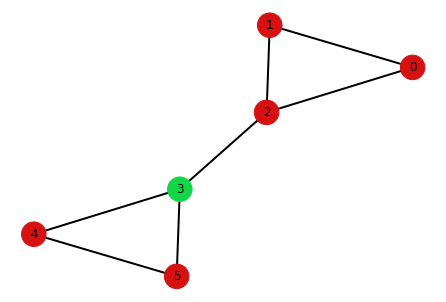

time step 2


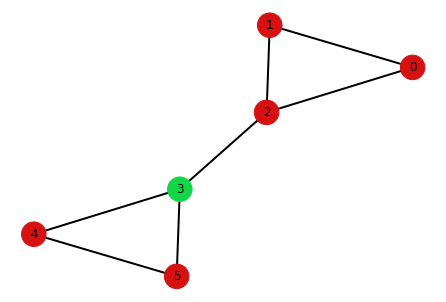

time step 3


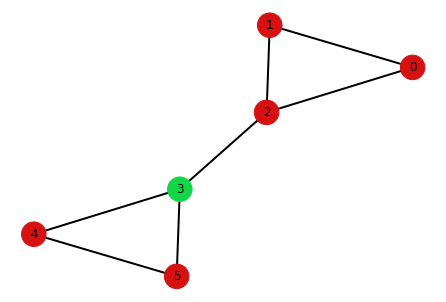

time step 4


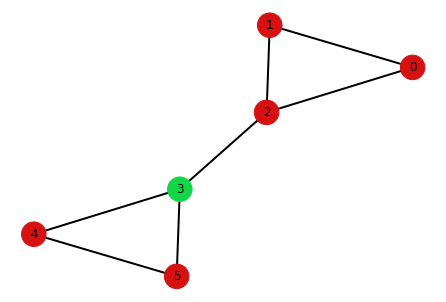

time step 5


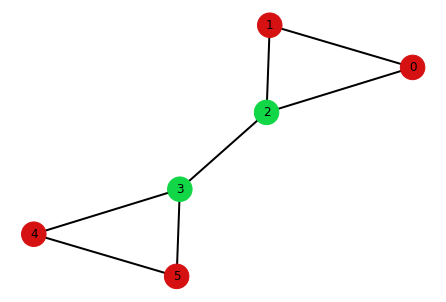

time step 6


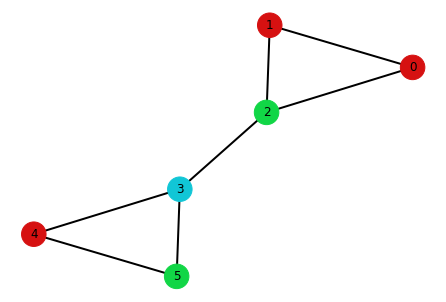

time step 7


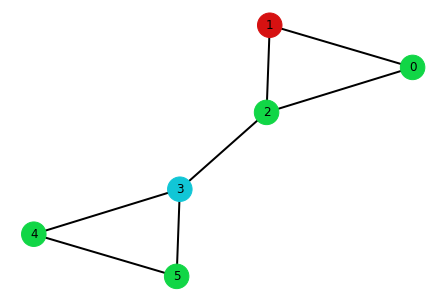

time step 8


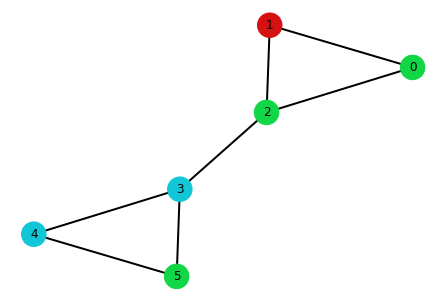

time step 9


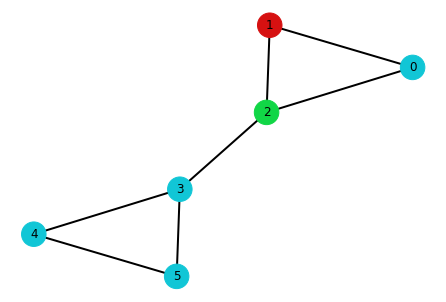

time step 10


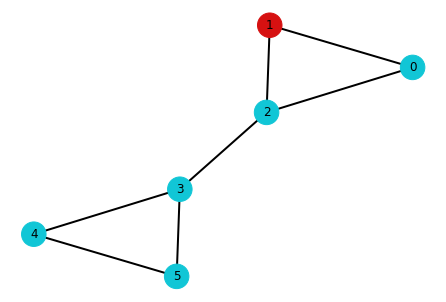

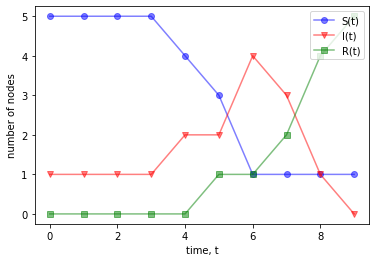

In [5]:
##### do not modify below here #####
##    run this code once you've written the run_SIR() function

G  = nx.Graph([(0,1),(0,2),(1,2),(2,3),(3,4),(3,5),(4,5)]) # a simple graph G

beta = 0.3
gmma = 0.3
flag = 1

St,It,Rt,xt = run_SIR(G,1,beta,gmma,flag)
plot_epidemicDynamics(St,It,Rt)

##### do not modify above here #####

***
## Problem 2 : The role of the degree distribution (55 pts total)

In this problem, you will investigate the role of the exposure graph's degree distribution $\Pr(k)$ on an epidemic's dynamics $I(t)$. This problem has three parts:
* `Problem 2-A`, you'll generate high/medium/low variance degree distributions.
* `Problem 2-B`, you'll run an epidemic on each and discuss the differences.
* `Problem 2-C`, you'll investigate the role of degree on _when_ a node gets infected.

### Problem 2-A (20 pts)

In `Problem 2-B` we'll use the Chung-Lu model to generate random graphs with a specified degree distribution. However, to see how varying the degree structure changes the epidemic's shape, we'll first need a low-dimensional way to vary the degree structure's shape. There are many ways to do this. Here, we'll use a 2-parameter distribution called a *stretched exponential*, which has the form:

<br/>
<center>$\Pr(x) \propto x^{\beta-1} \textrm{exp}(-\lambda \, x^{\beta})$,</center>

where $\beta\geq 0$ and $\lambda\geq 0$. When $\beta=1$, this distribution returns a standard (low variance) exponential distribution with parameter $\lambda$; when $\beta=2$, it decays like a standard (lower variance) Gaussian or Normal distribution; and when $\beta<1$, it decays more slowly than an exponential (higher variance). The parameter $\lambda$ is inversely related to the mean degree, so that $\lambda<1$ means a higher mean, and $\lambda>1$ means a lower mean.

* Use the provided function `drawFrom_SE(n,beta,lmbda)` to generate *three* lists, each containing $n=1000$ values. The three lists should be generated with different combinations of $\beta$ and $\lambda$, and should meet the following criteria:
  * one distribution should have "low" variance, one should have "high" variance, and one should be in between those, and
  * they should all have the roughly the same average value (e.g., in my solutions, the mean is about $2.3\pm0.1$).
* Modify the `plot_2CCDF()` function from `Problem Set 2` to display all three of these distributions together, i.e., make and apply a function `plot_3CCDF()`.
* Briefly describe the effect of increasing or decreasing $\beta$ and $\lambda$ on the shape of the plotted distributions, e.g., on the shape of the "body" (the middle part) and the upper tail of the distribution.

Hint: You will likely need to fiddle with different choices of parameters in order to find good settings. Try starting at $\beta=\lambda=1$, and then increasing or decreasing one, then the other parameter, until you get something reasonable when you plot it. For the "high" variance distribution, you'll want the maximum value you generate to be no higher than 100 or so.

In [91]:
def drawFrom_SE(n,beta,lmbda):
    # DO NOT MODIFY THIS FUNCTION
    # This function draws n values from a stretched exponential distribution with parameters beta,lambda
    # and then rounds them to integers for use as degrees. It returns these in a list x.

    xmin = 0.5  # minimum value 
    x    = [] # 
    for i in range(n):
        xi = int(round( (xmin**beta - (1/lmbda)*np.log(1-rnd.random()))**(1/beta) ))
        x.append(xi)

    return x

In [92]:
def plot_3CCDF(kis1,kis2,kis3):
    # input : three lists of degrees
    # output: one plot showing the CCDFs of the three degree distributions Pr(K>=k) for k>=1
    
    ki1_max = max(kis1)
    ki2_max = max(kis2)
    ki3_max = max(kis3)
    all_kis = []
    for i in kis1:
        all_kis.append(i)
    for i in kis2:
        all_kis.append(i)
    for i in kis3:
        all_kis.append(i)
    real_max = max(all_kis)
    
    # histograms
    icounts1, ibins1 = np.histogram(kis1, bins=[i for i in range(real_max+2)], density=True)
    icounts2, ibins2 = np.histogram(kis2, bins=[i for i in range(real_max+2)], density=True)
    icounts3, ibins3 = np.histogram(kis3, bins=[i for i in range(real_max+2)], density=True)
    
    icumcounts1 = np.cumsum(icounts1)
    icumcounts2 = np.cumsum(icounts2)
    icumcounts3 = np.cumsum(icounts3)
    
    icumcounts1 = np.insert(icumcounts1,0,0)
    icumcounts2 = np.insert(icumcounts2,0,0)
    icumcounts3 = np.insert(icumcounts3,0,0)

    # plots
    fig = plt.figure()
    ax1 = fig.add_subplot(111) # put multiple 
    
    plt.loglog(ibins1[1:-1], 1-icumcounts1[1:-1], 'rs', alpha=0.5, label='kis1')
    plt.loglog(ibins2[1:-1], 1-icumcounts2[1:-1], 'bo', alpha=0.5, label='kis2')
    plt.loglog(ibins3[1:-1], 1-icumcounts3[1:-1], 'y*', alpha=0.5, label='kis3')
    
    plt.title('CCDF, 3 degree distributions (loglog)')
    plt.xlabel('Degree, k')
    plt.ylabel('Pr(K>=k)')
    plt.legend(loc='upper right');
    plt.show()
    return


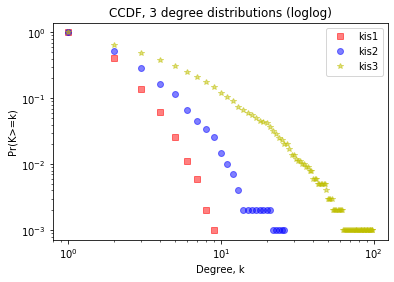

x1, mean = 1.653
x2, mean = 2.317
x3, mean = 4.805


In [93]:
n = 1000

beta1 = 1
beta2 = 0.75
beta3 = 0.5

lmbda1 = 0.9
lmbda2 = 0.9
lmbda3 = 0.9

##### do not modify below here #####
##    run this code once you've written the plot_3CCDF() function

x1 = drawFrom_SE(n,beta1,lmbda1)
x2 = drawFrom_SE(n,beta2,lmbda2)
x3 = drawFrom_SE(n,beta3,lmbda3)

plot_3CCDF(x1,x2,x3)

print(f'x1, mean = {sum(x1)/n}')
print(f'x2, mean = {sum(x2)/n}')
print(f'x3, mean = {sum(x3)/n}')

Dropping beta1 down from 1 seems to scale down the graph of the CCDF on the x-axis, kind of scrunching it in towards x=0. 

Lambda is similar, but in the reverse direction, and that it doesn't seem to directly scale them. It floats the mean of the CCDF out further as the value of lambda shrinks. If it grows at all, the curve essentially disappears and becomes a sheer cliff. 

### Problem 2-B (15 pts)

Now, using $\beta=\gamma=0.4$ (at the critical threshold of $R_0$):
* Use the built-in `networkx` Chung-Lu graph generator to make a graph for each of your three degree distributions.
* Then, run your SIR simulation on each graph, and plot the corresponding epidemic's dynamics.
* Discuss what you see as differences or similarities among or between the three cases, and offer an explanation _in terms of the role that node degree plays in spreading the epidemic_. Remember that the _only_ thing different about these three graphs is the degree structure. (You may find it useful to use `drawGz()` to visualize them.)

Hint: You may need to re-run the simulation on the same graphs multiple times in order to get three good runs (since each run will start the epidemic in a different location, and occasionally the epidemic may not take off). Alternatively, you can increase the number of initially infected nodes to a small integer (maybe 5 at most). When comparing epidemics, don't forget to look at how _long_ they last.

In [94]:
beta = 0.4
gmma = 0.4
flag = 0

G1 = nx.expected_degree_graph(x1, seed=None, selfloops=False)
G2 = nx.expected_degree_graph(x2, seed=None, selfloops=False)
G3 = nx.expected_degree_graph(x3, seed=None, selfloops=False)

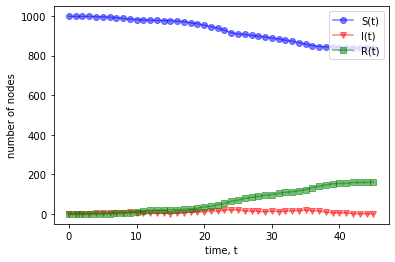

In [96]:
St1,It1,Rt1,xt1 = run_SIR(G1,1,beta,gmma,flag)
plot_epidemicDynamics(St1,It1,Rt1)

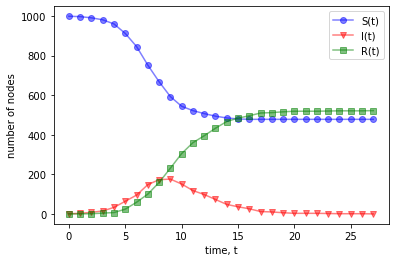

In [97]:
St2,It2,Rt2,xt2 = run_SIR(G2,1,beta,gmma,flag)
plot_epidemicDynamics(St2,It2,Rt2)

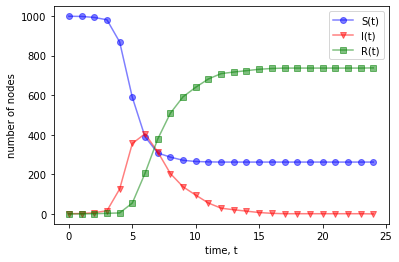

In [100]:
St3,It3,Rt3,xt3 = run_SIR(G3,1,beta,gmma,flag)
plot_epidemicDynamics(St3,It3,Rt3)

As we allow for greater variance in the degree distribution, we see that the pandemic has a much greater 'success'... Not the correct usage of that word really -- the infection does its job and infects more and faster. It really exhausts through the availability of S very rapidly. Obviously, as we raise the average degree, the infection will run more quickly and infecting more overall, but here we've shown that simply by varying the variance (haha). 

### Problem 2-C (20 pts)

High degree nodes, which are more common under high variance degree distributions, play a special role in epidemics. Let's investigate.
* Using the `xt` output variable from your `run_SIR()` function, make three scatter plots of the time of infection $t_i$ as a function of node degree $k_i$, one for each network.
* For each plot, calculate and report the correlation coefficient `r = np.corrcoef(x,y)[0,1]` between your $x$ and $y$ variables.
* Finally, discuss any patterns you see within and across your high/medium/low variance networks from this perspective, and use the correlation coefficients you calculate to offer an explanation (in terms of the network structure and the rules of the SIR epidemic) as to why that pattern exists.

Hint: Don't plot values where $t_i=-1$, which is a special value indicating that node $i$ was never infected.

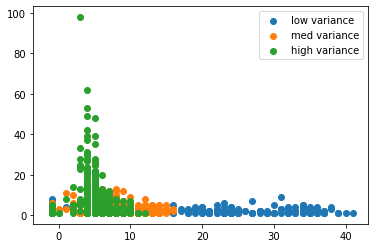

In [114]:
# YOUR CODE
xt1n = []
x1n = []
xt2n = []
x2n = []
xt3n = []
x3n = []

for timepoint, degree in zip(xt1.values(), x1):
    if timepoint != -1:
        xt1n.append(timepoint)
        x1n.append(degree)
        
for timepoint, degree in zip(xt2.values(), x2):
    if timepoint != -1:
        xt2n.append(timepoint)
        x2n.append(degree)
    
for timepoint, degree in zip(xt3.values(), x3):
    if timepoint != -1:
        xt3n.append(timepoint)
        x3n.append(degree)
        
        
plt.scatter([xt1[val] for val in xt1], x1, label='low variance')
plt.scatter([xt2[val] for val in xt2], x2, label='med variance')
plt.scatter([xt3[val] for val in xt3], x3, label='high variance')

plt.legend()

In the high variance version, the infected timepoints seem to be much lower. As we lower the variance, they stretch out, and we 'flatten the curve'. 

***
### Problem 2-D (*10 pts extra credit*) : Flattening an epidemic

Complete this section of the in-class lab.

Using your SIR simulation, conduct the following three mini-experiments. For these, use the built-in `.gnp_random_graph(n, p)` network generator in `networkx`. Recall that `p` is the probability that an edge exists, and we choose it by first choosing the _mean degree_ $c$ (see Lecture Notes 3). The idea here is that the first experiment sets up your baseline for an SIR epidemic on a network, and then we'll first vary one parameter, and then vary a different parameter, to investigate the effects these parameters have on the dynamics of the epidemic. To do this, you'll want to plot the $S(t)$, $I(t)$, $R(t)$ functions after each simulation.

Experiment 3.1: simulate a basic epidemic:
* set $n=200$ and $c=6$
* note around what time step $I(t)$ peaks, and how many time steps it mostly spans.

Experiment 3.2: simulate the effect of reduced transmission (e.g., hand washing!):
* lower $\beta$; keep $\gamma$ the same, $n=200$ and $c=6$

Experiment 3.3: simulate the effect of "social distancing" (e.g., self-quarantine, staying at home, etc.):
* lower $c$ in $G(n,p)$; keep $\beta=\gamma$, $n=200$

As before, you'll want to run each setting several times to get a sense of what the epidemic tends to do. Start by lowering $\beta$ and $c$ only a little, and then keep lowering them until you see something change. Then, discuss with your teammates what you found, and answer the following specific questions:
1. What effect does lowering $\beta$ (reducing the likelihood of transmission) have on $I(t)$, compared to experiment 3.1? How much reduced transmission would you need _everyone_ to do to achieve a real "flattening" of the epidemic? Do you think that's realistic?
* What effect does lowering $c$ (reducing the likelihood of transmission) have on $I(t)$?, compared to experiment 3.1? How much social distancing would you need_everyone_ to do to achieve the results you found in experiment 3.3? (Consider what a typical $c$ might be for _you_ during a normal day. Is $c=6$ realistic?)
* Which has a larger effect on $I(t)$, reduced transmission or social distancing?

In [ ]:

# YOUR CODE


Your discussion

***
***

## Problem 3 : Reading the literature (*10 pts extra credit*)

Choose a paper from the [Supplemental Reading list on the external course webpage](http://tuvalu.santafe.edu/~aaronc/courses/3352/). Read the paper (the whole paper, not just the abstract). Think about what it says. Then, write 1-3 sentences for each of the following questions in a way that clearly summarizes the work, and its context.
* What paper did you choose?
* What was the research question?
* What was the approach the authors took to answer that question?
* What did they do well?
* What could they have done better?
* What extensions can you envision?


Do not copy any text from the paper itself; write your own summary, in your own words in Markdown in the corresponding box below. Be sure to answer each of the five questions. The amount of extra credit will depend on the accuracy and thoughtfulness of your answers.

Hint: This is a good way to generate some ideas for your class project (your proposal for that is due on **February 27th**. Also, even if you don't understand everything in the paper, that's okay. Do your best to summarize what you did understand.

* *What paper did you choose?*<br/>
Give the Authors, Title, Publication Venue, Year
<br/>

* *What was the research question?*<br/>
Your answer here
<br/>

* *What was the approach the authors took to answer that question?*<br/>
Your answer here
<br/>

* *What did they do well?*<br/>
Your answer here
<br/>

* *What could they have done better?*<br/>
Your answer here
<br/>

* *What extensions can you envision?*<br/>
Your answer here